<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/Full_Validation_Imagenet_VGG_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
colorization_path = '/content/drive/MyDrive/colorization'
!tar -zxf /content/drive/MyDrive/colorization/val.tar.gz

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [3]:

def stack_lab(l, ab):
  return torch.cat((l, ab), dim=-3)

def lab2rgb(lab, to_numpy):
  dims = len(lab.shape)
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0)) if dims==3 else lab.permute((0,2,3,1))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy(rgb).permute(2,0,1) if dims==3 else torch.from_numpy(rgb).permute((0,3,1,2))

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using Imagenet validation set

In [4]:
# image processing rgb to lab
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.data = datasets.ImageFolder(folder_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, _ = self.data[index]

        if self.transform:
            image = self.transform(image)

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))


        return L, ab

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256,256))
])

data_dir = '/content/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/'
# data_dir = '/content/ILSVRC2012_img_val_subset'
dataset = ColorizationDataset(data_dir, transform)


In [5]:
train_size = int(.5* len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator()
generator.manual_seed(0)
train_data, val_data = random_split(dataset, [train_size, val_size], generator=generator)


In [6]:
gray, chrome = train_data[0]
gray.shape, chrome.shape

(torch.Size([1, 256, 256]), torch.Size([2, 256, 256]))

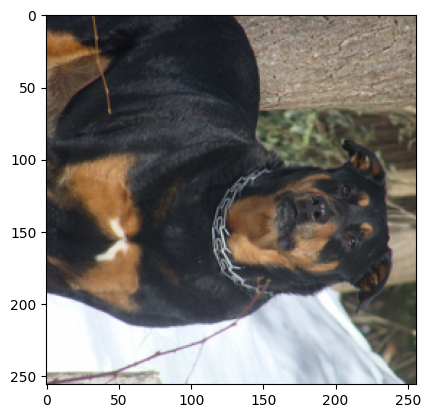

In [7]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# III. Training Experimentation

## 0. utils

In [8]:
from tqdm import tqdm

def train_loop(model, loader, optimizer, backprop_loss=1):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0

    for grayscale_images, colored_images in tqdm(loader, leave=False):
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss1 = nn.L1Loss()(predicted_images, colored_images)
        loss2 = nn.MSELoss()(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss = loss1 + loss2 if backprop_loss==0 else loss1 if backprop_loss==1 else loss2
        loss.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        running_loss2 += loss2.item()

    # Calculate average loss
    average_loss1 = running_loss1 / len(loader)
    average_loss2 = running_loss2 / len(loader)

    return average_loss1, average_loss2

def plot_loss(loss, title, save_path):
    epochs = range(len(loss))

    # Plotting the losses
    plt.plot(epochs, loss)
    # Customize the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)

    # Save the plot
    plt.savefig(save_path)
    plt.show()

    # Close the plot to free up resources
    plt.close()


# Train RESNET UNet on imagenet validation set

In [9]:
! pip install -qU segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.3 MB/s eta 0:00:00


In [10]:
from torchvision.models.resnet import resnet101
import segmentation_models_pytorch as smp

class UNet(nn.Module):
  def __init__(self, encoder_name, encoder_weights = 'imagenet', freeze_encoder = True):
    super().__init__()

    self.model = smp.Unet(encoder_name, encoder_weights=encoder_weights, decoder_use_batchnorm=True, in_channels=1)
    self.model.segmentation_head[0] = nn.Conv2d(16, 2, kernel_size=3, padding=1)

    if freeze_encoder:
      for param in self.model.encoder.parameters():
        param.requires_grad = False

  def forward(self, x):
    return self.model(x)

# res_unet= UNet(encoder_name='resnet152',encoder_weights='imagenet',freeze_encoder=True)
vgg_unet= UNet(encoder_name='vgg19_bn',encoder_weights='imagenet',freeze_encoder=True)
vgg_unet.model.load_state_dict(torch.load('/content/drive/MyDrive/colorization/models/small-VGG-UNET-L2.pth'))



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 81.2MB/s]


<All keys matched successfully>

In [11]:
# config
model_name = 'imagenet-frozenvgg'
model = vgg_unet
backprop_loss = 2
batch_size = 32
model.to(device)

# Initialize U-Net model and loader and optimizer
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters())

# training loop
l1_hist = []
l2_hist = []

Epoch 1/20:  MAE Loss: 9.10239431132441, MSE Loss: 188.56729529885683


Epoch 2/20:  MAE Loss: 8.79960546408163, MSE Loss: 175.34150687020147


Epoch 3/20:  MAE Loss: 8.555998080221894, MSE Loss: 164.59493414642256


Epoch 4/20:  MAE Loss: 8.280249712717199, MSE Loss: 152.96063837309933


Epoch 5/20:  MAE Loss: 8.026493260927518, MSE Loss: 142.64275269374212


Epoch 6/20:  MAE Loss: 7.780423484494924, MSE Loss: 133.4785413424987


Epoch 7/20:  MAE Loss: 7.566125248399232, MSE Loss: 125.73407063398825


Epoch 8/20:  MAE Loss: 7.362802546347498, MSE Loss: 119.00271856205542


Epoch 9/20:  MAE Loss: 7.217119929735618, MSE Loss: 114.11668275994109


Epoch 10/20:  MAE Loss: 7.062529930373287, MSE Loss: 108.95551502003389


Epoch 11/20:  MAE Loss: 6.917789067758624, MSE Loss: 104.53434898786227


Epoch 12/20:  MAE Loss: 6.819305074794213, MSE Loss: 101.55108718676945


Epoch 13/20:  MAE Loss: 6.726521140169305, MSE Loss: 98.7802585689613


Epoch 14/20:  MAE Loss: 6.60299954389977, MSE Loss: 94.99389113794507


Epoch 15/20:  MAE Loss: 6.531774081842369, MSE Loss: 92.99193300310608


Epoch 16/20:  MAE Loss: 6.455005004887691, MSE Loss: 90.96138645377


Epoch 17/20:  MAE Loss: 6.381459522735128, MSE Loss: 88.69664287811045


Epoch 18/20:  MAE Loss: 6.307014904363686, MSE Loss: 86.74369705180683


Epoch 19/20:  MAE Loss: 6.241865683089742, MSE Loss: 84.91940834942986


Epoch 20/20:  MAE Loss: 6.164173976234768, MSE Loss: 82.95168475177891


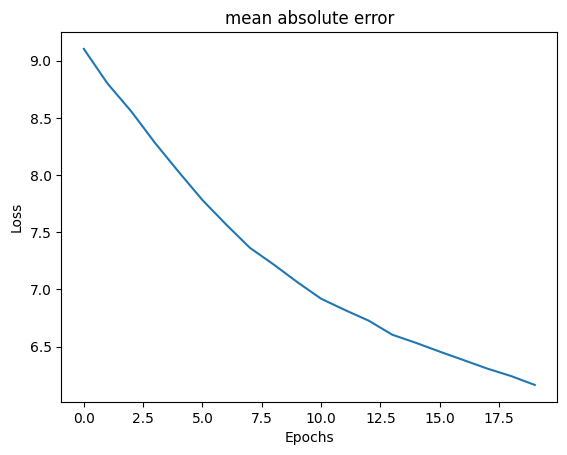

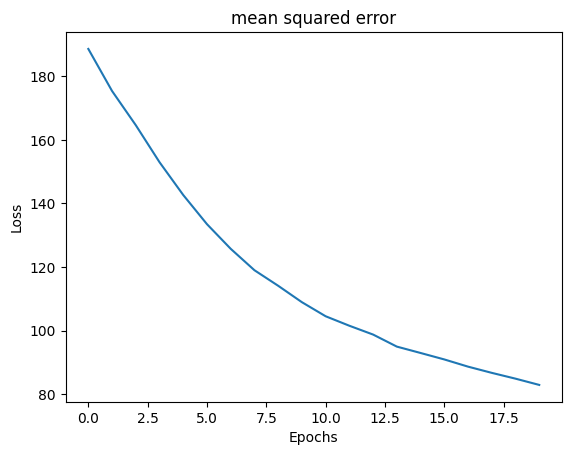

In [ ]:
epochs = 20
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [16]:
model.load_state_dict(torch.load('/content/drive/MyDrive/colorization/models/imagenet-frozenvgg.pth'))
small_model = UNet(encoder_name='vgg19_bn',encoder_weights='imagenet',freeze_encoder=True)
small_model.model.load_state_dict(torch.load('/content/drive/MyDrive/colorization/models/small-VGG-UNET-L2.pth'))

model.to(device)
small_model.to(device)

UNet(
  (model): Unet(
    (encoder): VGGEncoder(
      (features): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace=True)
        (

In [13]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00


In [14]:
from torch.types import Device
from lpips import LPIPS

lpips_alex = LPIPS(net='alex')

def lpips_evaluate(model, loader):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colors in loader:
            grayscale_images = grayscale_images.to(device)
            colors = colors.to(device)

            # Forward pass
            predicted_colors = model(grayscale_images)

            # Compute the loss
            predicted_rgb = to_rgb(grayscale_images.cpu(), predicted_colors.cpu(), to_numpy = False)
            label_rgb = to_rgb(grayscale_images.cpu(), colors.cpu(), to_numpy = False)

            loss = lpips_alex(predicted_rgb, label_rgb)

            # Accumulate loss
            running_loss += loss.sum().item() / len(loss)

    # Calculate average loss
    average_loss = running_loss / len(loader)

    return average_loss


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 205MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [50]:
testloader = DataLoader(val_data, batch_size=32)
model_lpips = lpips_evaluate(model, testloader)
small_model_lpips = lpips_evaluate(small_model, testloader)

print(f'LPIPS results for VGG backbone:{model_lpips}')
print(f'LPIPS results for small VGG backbone:{small_model_lpips}')

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


LPIPS results for VGG backbone:0.12079738832228934
LPIPS results for small VGG backbone:0.12226015262667785


# Colorizing Unseen Data with implemented model

18302


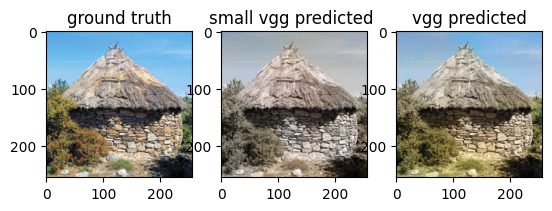

In [48]:
import random
model.eval()
small_model.eval()

index = random.randint(0,len(val_data))
input, label = val_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
output = model(input.unsqueeze(0)).squeeze()
small_output = small_model(input.unsqueeze(0)).squeeze()

rgb_pred = to_rgb(input.cpu(), output.cpu())
small_rgb_pred = to_rgb(input.cpu(), small_output.cpu())

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3)


axes[0].imshow(rgb_label)
axes[0].set_title('ground truth')

axes[1].imshow(small_rgb_pred)
axes[1].set_title('small vgg predicted ')

axes[2].imshow(rgb_pred)
axes[2].set_title('vgg predicted')

print(index)

In [49]:
fig.savefig("/content/drive/MyDrive/colorization/figures/small-vs-big-vgg-9")